# DeepONet: 1D Darcy Flow

In this example, we aim to learn the nonlinear Darcy operator for a 1D system. A variant of the nonlinear 1D Darcy's equation is written as:

$$ \frac{d}{dx} \left( -\kappa(u(x)) \frac{du}{dx} \right) = f(x), \quad x \in $$

where:
*   **`u(x)`** is the **solution field** (e.g., pressure or hydraulic head).
*   The solution-dependent permeability is `κ(u(x)) = 0.2 + u^2(x)`.
*   The **input term `f(x)`** is a Gaussian random field defined as `f(x) ~ GP(0, k(x, x'))` such that `k(x, x') = σ^2 exp(-||x - x'||^2 / (2ℓ_x^2))`, where `ℓ_x = 0.04` and `σ^2 = 1.0`.
*   Homogeneous Dirichlet boundary conditions **`u(0) = 0`** and **`u(1) = 0`** are considered at the domain boundaries.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import trange
import os
from scipy.sparse import diags, csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.stats import multivariate_normal

print("Warning: 'plotting_specs' module not found. Using default values.")
colors = {"DeepONet": "red", "Groundtruth": "black"}
labels = {"DeepONet": "DeepONet", "Groundtruth": "Groundtruth"}
titles = {}

plt.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Times New Roman"


# --- Base Class for Dataset (for standalone execution) ---
class OperatorDataset(torch.utils.data.Dataset):
    def __init__(self, input_size, output_size, total_n_functions,
                 total_n_samples_per_function, n_functions_per_sample,
                 n_points_per_sample):
        self.input_size = input_size
        self.output_size = output_size
        self.total_n_functions = total_n_functions
        self.total_n_samples_per_function = total_n_samples_per_function
        self.n_functions_per_sample = n_functions_per_sample
        self.n_points_per_sample = n_points_per_sample

    def sample_info(self) -> dict:
        raise NotImplementedError

    def sample_inputs(self, info, n_samples) -> torch.tensor:
        raise NotImplementedError

    def compute_outputs(self, info, inputs) -> torch.tensor:
        raise NotImplementedError


# --- Data Generation ---
def generate_dataset(plot=False):
    os.makedirs('src/Datasets/Darcy', exist_ok=True)

    def permeability(s):
        return 0.2 + s**2

    def sample_source_function(n_points):
        l = 0.04
        sigma = 1.0
        x_coords = np.linspace(0, 1, n_points)
        K = sigma**2 * np.exp(-0.5 * (x_coords[:, np.newaxis] - x_coords[np.newaxis, :])**2 / l**2)
        K += 1e-6 * np.eye(n_points)
        
        def source_function_sampler():
            return multivariate_normal.rvs(mean=np.zeros_like(x_coords), cov=K)
        return source_function_sampler

    def solve_fd(n_points, u_func):
        x = np.linspace(0, 1, n_points)
        dx = x[1] - x[0]
        u = u_func
        s = np.zeros(n_points)

        for _ in range(100):
            kappa = permeability(s)
            main_diag = (kappa[1:] + kappa[:-1]) / dx**2
            upper_diag = -kappa[1:-1] / dx**2
            lower_diag = -kappa[1:-1] / dx**2
            
            A = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], 
                      shape=(n_points-2, n_points-2), format='csc')
            
            try:
                s_interior = spsolve(A, u[1:-1])
                s_new = np.zeros(n_points)
                s_new[1:-1] = s_interior
                s = 0.5 * s_new + 0.5 * s
            except Exception:
                break
        
        return x, s, u

    n_data = 40
    n_functions = 1000
    np.random.seed(0)

    if plot:
        fig, axs = plt.subplots(4, 6, figsize=(15, 10), dpi=300)
        source_sampler = sample_source_function(n_data)
        for i in range(min(24, n_functions)):
            ax = axs[i//6, i%6]
            u_fd = source_sampler()
            x_fd, s_fd, _ = solve_fd(n_data, u_fd)
            ax.plot(x_fd, s_fd, 'b', linewidth=2, label='Solution $s(x)$')
            ax.plot(x_fd, u_fd, 'g', linewidth=2, label='Source $u(x)$')
            ax.set_title(f"Sample {i+1}")
            ax.grid(True)
        handles, legend_labels = axs[0,0].get_legend_handles_labels()
        fig.legend(handles, legend_labels, loc='lower center', ncol=2)
        plt.tight_layout(rect=[0, 0.05, 1, 1])
        plt.savefig('visualize.pdf')
        print("Saved visualization plot to visualize.pdf")
    else:
        xs, f_xs, ys, tf_ys = [], [], [], []
        source_sampler = sample_source_function(n_data)
        for _ in trange(n_functions, desc="Generating 1D Darcy dataset"):
            u_fd = source_sampler()
            x_fd, s_fd, _ = solve_fd(n_data, u_fd)
            xs.append(x_fd); f_xs.append(u_fd); ys.append(x_fd); tf_ys.append(s_fd)

        xs, f_xs = torch.tensor(np.array(xs), dtype=torch.float32), torch.tensor(np.array(f_xs), dtype=torch.float32)
        ys, tf_ys = torch.tensor(np.array(ys), dtype=torch.float32), torch.tensor(np.array(tf_ys), dtype=torch.float32)

        n_train = int(0.8 * n_functions)
        train = {"x": xs[:n_train], "f": f_xs[:n_train], "y": ys[:n_train], "tf_y": tf_ys[:n_train]}
        test = {"x": xs[n_train:], "f": f_xs[n_train:], "y": ys[n_train:], "tf_y": tf_ys[n_train:]}
        torch.save(train, 'nonlineardarcy_train.pt')
        torch.save(test, 'nonlineardarcy_test.pt')
        print("Dataset generated and saved.")

# --- Dataset Classes (FIXED) ---
class DarcySrcDataset(OperatorDataset):
    def __init__(self, test=False, device="cuda", n_functions_per_sample=10):
        path = './nonlineardarcy_test.pt' if test else './nonlineardarcy_train.pt'
        mat = torch.load(path)
        xs, ys = mat["x"].unsqueeze(-1), mat["f"].unsqueeze(-1)
        
        # FIX: Explicitly pass all required arguments to the parent class.
        super().__init__(
            input_size=(1,),
            output_size=(1,),
            total_n_functions=ys.shape[0],
            total_n_samples_per_function=ys.shape[1],
            n_functions_per_sample=n_functions_per_sample,
            n_points_per_sample=ys.shape[1]
        )
        
        self.xs = xs.to(torch.float32).to(device)
        self.ys = ys.to(torch.float32).to(device)
        self.device = device

    def sample_info(self) -> dict:
        indices = torch.randint(0, self.total_n_functions, (self.n_functions_per_sample,), device=self.device)
        return {"function_indicies": indices}

    def sample_inputs(self, info, n_samples) -> torch.tensor:
        return self.xs[info["function_indicies"]]

    def compute_outputs(self, info, inputs) -> torch.tensor:
        return self.ys[info["function_indicies"]]

class DarcyTgtDataset(OperatorDataset):
    def __init__(self, test=False, device="cuda", n_functions_per_sample=10):
        train_mat = torch.load('./nonlineardarcy_train.pt')
        self.mean = train_mat["tf_y"].mean()
        self.std = train_mat["tf_y"].std()
        
        path = './nonlineardarcy_test.pt' if test else './nonlineardarcy_train.pt'
        mat = torch.load(path)
        xs, ys = mat["y"].unsqueeze(-1), mat["tf_y"].unsqueeze(-1)

        # FIX: Explicitly pass all required arguments to the parent class.
        super().__init__(
            input_size=(1,),
            output_size=(1,),
            total_n_functions=ys.shape[0],
            total_n_samples_per_function=ys.shape[1],
            n_functions_per_sample=n_functions_per_sample,
            n_points_per_sample=ys.shape[1]
        )
        
        self.xs = xs.to(torch.float32).to(device)
        self.ys = ((ys - self.mean) / self.std).to(torch.float32).to(device)
        self.device = device

    def sample_info(self) -> dict:
        indices = torch.randint(0, self.total_n_functions, (self.n_functions_per_sample,), device=self.device)
        return {"function_indicies": indices}

    def sample_inputs(self, info, n_samples) -> torch.tensor:
        return self.xs[info["function_indicies"]]

    def compute_outputs(self, info, inputs) -> torch.tensor:
        return self.ys[info["function_indicies"]]

# --- Plotting Function ---
def plot_transformation_darcy(u_locs, u_vals, s_locs, s_true, s_pred, info, logdir):
    model_type = info["model_type"]
    color = colors.get(model_type, "red")
    label = labels.get(model_type, "DeepONet")

    for i in range(min(u_locs.shape[0], 5)):
        fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
        
        axs[0].plot(u_locs[i].cpu(), u_vals[i].cpu(), color="green")
        axs[0].set_title("Input Function $f(x)$")
        axs[0].set_xlabel("$x$")
        axs[0].set_ylabel("$f(x)$")
        axs[0].grid(True, linestyle='--')

        axs[1].plot(s_locs[i].cpu(), s_true[i].cpu(), color="black", label="Groundtruth")
        axs[1].plot(s_locs[i].cpu(), s_pred[i].cpu(), color=color, linestyle='--', label=label)
        axs[1].set_title("Solution $u(x)$ (Normalized)")
        axs[1].set_xlabel("$y$")
        axs[1].set_ylabel("$u(y)$")
        axs[1].grid(True, linestyle='--')
        axs[1].legend()

        plt.tight_layout()
        plot_name = f"{logdir}/Darcy_result_{i}.pdf"
        plt.savefig(plot_name)
        plt.close(fig)

# --- DeepONet Model ---
class DeepONet(nn.Module):
    def __init__(self, branch_input_size, trunk_input_size, p_dim, hidden_size):
        super(DeepONet, self).__init__()
        self.branch = nn.Sequential(
            nn.Linear(branch_input_size, hidden_size), nn.GELU(),
            nn.Linear(hidden_size, hidden_size), nn.GELU(),
            nn.Linear(hidden_size, p_dim)
        )
        self.trunk = nn.Sequential(
            nn.Linear(trunk_input_size, hidden_size), nn.GELU(),
            nn.Linear(hidden_size, hidden_size), nn.GELU(),
            nn.Linear(hidden_size, p_dim)
        )

    def forward(self, u_data, y_locs):
        branch_out = self.branch(u_data)
        trunk_out = self.trunk(y_locs)
        return torch.einsum('bi,bji->bj', branch_out, trunk_out).unsqueeze(-1)

# --- Main Training Script ---
def train_deeponet():
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"
    print(f"Using device: {device}")

    logdir = "darcy_deeponet_results"
    os.makedirs(logdir, exist_ok=True)

    learning_rate = 1e-3
    epochs = 15000
    p_dim = 128
    hidden_dim = 256
    n_functions_per_batch = 64

    if not os.path.exists('nonlineardarcy_train.pt'):
        print("Dataset not found. Generating data first...")
        generate_dataset(plot=False)

    src_train = DarcySrcDataset(test=False, device=device, n_functions_per_sample=n_functions_per_batch)
    tgt_train = DarcyTgtDataset(test=False, device=device, n_functions_per_sample=n_functions_per_batch)
    src_test = DarcySrcDataset(test=True, device=device, n_functions_per_sample=n_functions_per_batch)
    tgt_test = DarcyTgtDataset(test=True, device=device, n_functions_per_sample=n_functions_per_batch)

    model = DeepONet(
        branch_input_size=src_train.total_n_samples_per_function,
        trunk_input_size=1,
        p_dim=p_dim,
        hidden_size=hidden_dim
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    pbar = trange(epochs, desc="Training")
    for epoch in pbar:
        model.train()
        
        info = src_train.sample_info()
        u_vals = src_train.compute_outputs(info, None).squeeze(-1)
        s_locs = tgt_train.sample_inputs(info, None)
        s_true = tgt_train.compute_outputs(info, s_locs)

        s_pred = model(u_vals, s_locs)
        loss = F.mse_loss(s_pred, s_true)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % 100 == 0:
            pbar.set_postfix({"Loss": f"{loss.item():.4e}", "LR": f"{scheduler.get_last_lr()[0]:.2e}"})

    print("Training finished.")

    model.eval()
    with torch.no_grad():
        info = src_test.sample_info()
        
        u_locs_test = src_test.sample_inputs(info, None)
        u_vals_test = src_test.compute_outputs(info, None)
        
        s_locs_test = tgt_test.sample_inputs(info, None)
        s_true_test = tgt_test.compute_outputs(info, s_locs_test)
        s_pred_test = model(u_vals_test.squeeze(-1), s_locs_test)

        s_true_denorm = s_true_test * tgt_test.std.to(device) + tgt_test.mean.to(device)
        s_pred_denorm = s_pred_test * tgt_test.std.to(device) + tgt_test.mean.to(device)
        
        l2_error = torch.sqrt(torch.mean(torch.sum((s_pred_denorm - s_true_denorm)**2, dim=1)) / torch.mean(torch.sum(s_true_denorm**2, dim=1)))
        print(f"Mean Relative L2 error on test batch: {l2_error.item():.4f}")

        print("Generating plots...")
        plot_info = {"model_type": "DeepONet"}
        plot_transformation_darcy(
            u_locs=u_locs_test, u_vals=u_vals_test,
            s_locs=s_locs_test, s_true=s_true_test, s_pred=s_pred_test,
            info=plot_info, logdir=logdir
        )
        print(f"Saved qualitative plots to '{logdir}/'")

if __name__ == "__main__":
    train_deeponet()

Using device: mps


Training: 100%|██████████| 15000/15000 [00:49<00:00, 300.69it/s, Loss=6.5639e-04, LR=1.07e-07]


Training finished.
Mean Relative L2 error on test batch: 0.0236
Generating plots...
Saved qualitative plots to 'darcy_deeponet_results/'


# DeepONet: Derivative

Using device: mps
Generating polynomial data...
Model parameters: 423
Training DeepONet...


Training: 100%|██████████| 500/500 [00:29<00:00, 16.98it/s, Train Loss=0.000443, Val Loss=0.000554, LR=0.002500]


Plotting results...


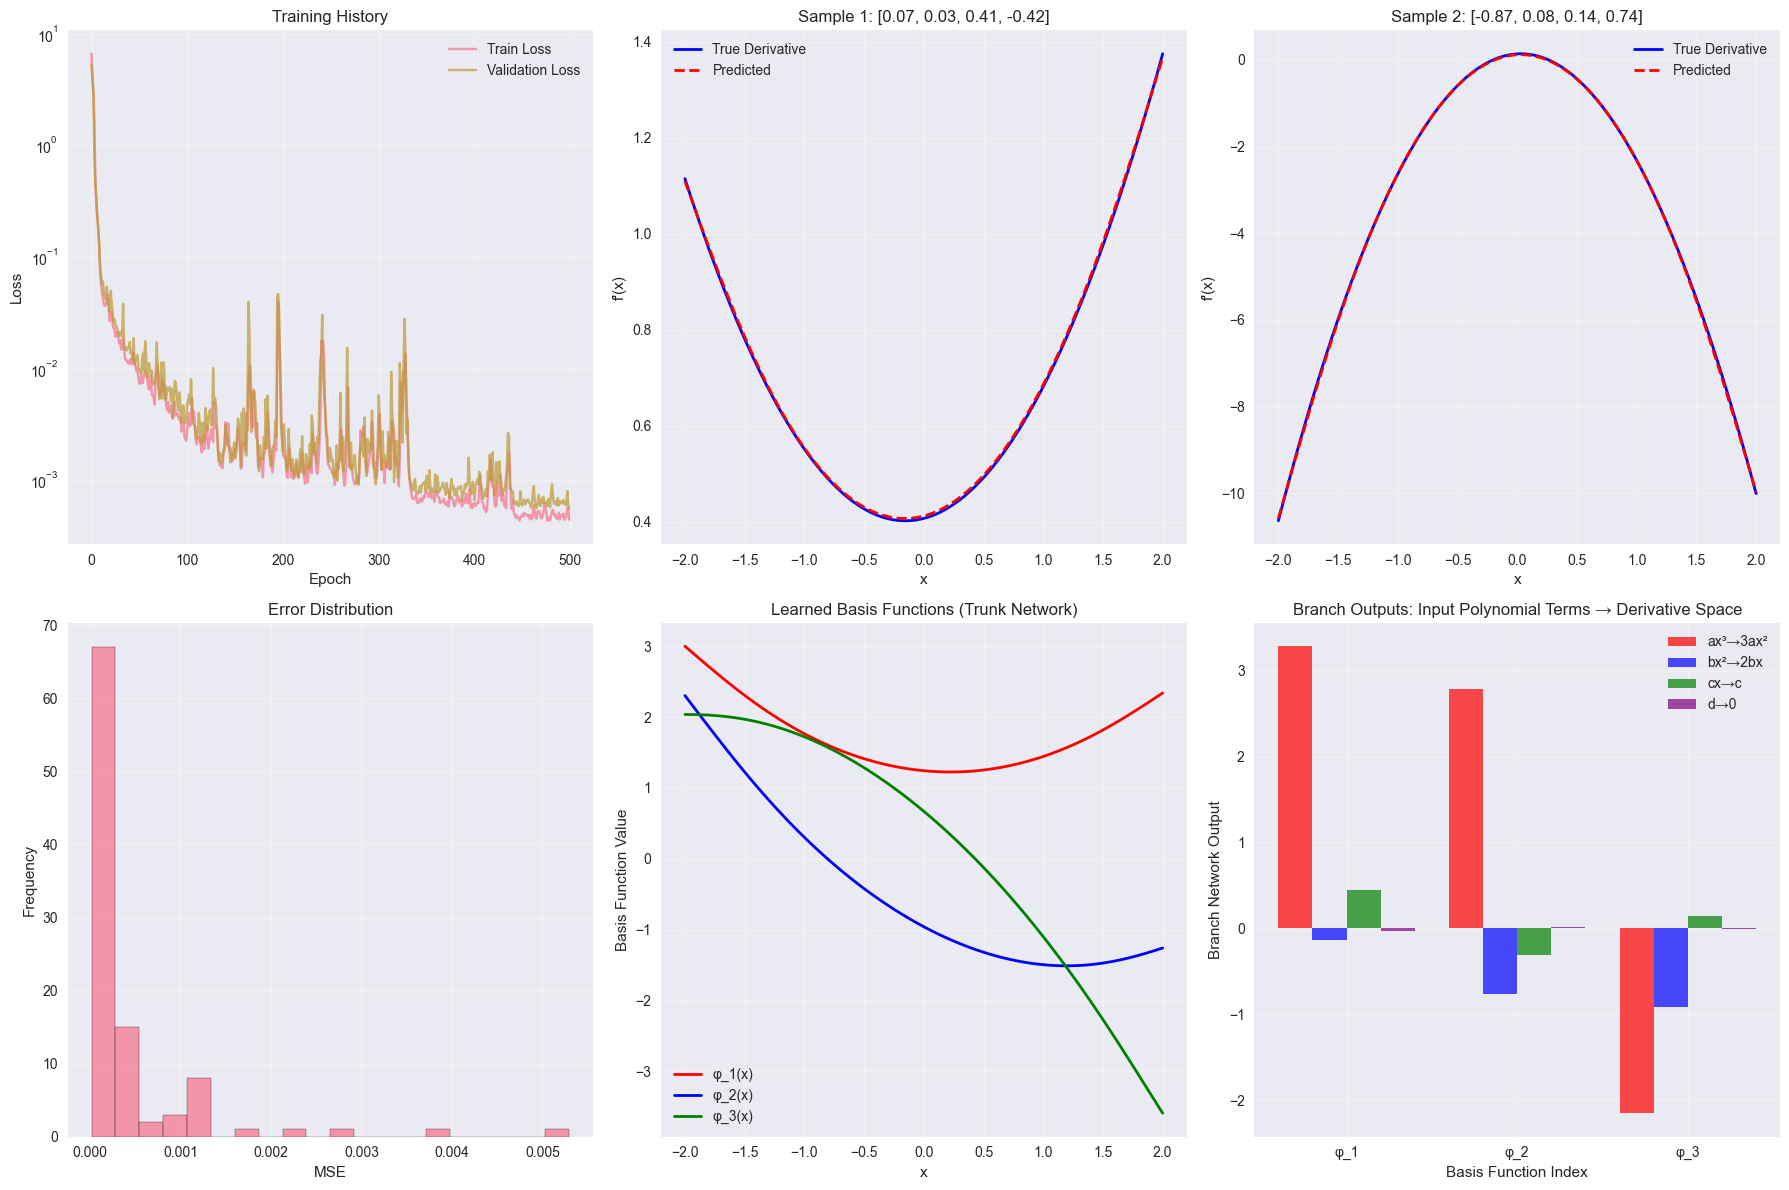

Extracting basis function equations...

EXTRACTED BASIS FUNCTION EQUATIONS

Basis Function 1:
  Equation: φ_1(x) = -0.0023x^4 -0.0016x^3 +0.3693x^2 -0.1590x +1.2414
  Degree: 4
  R² Score: 0.999967
  Coefficients: [-0.00228687 -0.00161692  0.36926924 -0.15899835  1.24142984]

Basis Function 2:
  Equation: φ_2(x) = 0.0016x^4 +0.0020x^3 +0.3679x^2 -0.9017x -0.9610
  Degree: 4
  R² Score: 0.999990
  Coefficients: [ 0.00158077  0.00195991  0.36786151 -0.90172357 -0.96095946]

Basis Function 3:
  Equation: φ_3(x) = -0.0003x^4 +0.0001x^3 -0.3641x^2 -1.4115x +0.6733
  Degree: 4
  R² Score: 0.999996
  Coefficients: [-3.02901817e-04  7.05131852e-05 -3.64087023e-01 -1.41147937e+00
  6.73332546e-01]

DEEPONET DECOMPOSITION:
Any derivative can be approximated as:
f'(x) ≈ w₁φ₁(x) + w₂φ₂(x) + w₃φ₃(x) + bias
where w₁, w₂, w₃ come from the branch network
Final Test MSE: 0.000619

Model Summary:
- Device: mps
- Number of basis functions: 3
- Training samples: 1600
- Validation samples: 200
- Test sampl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Device selection with CUDA/CPU/MPS support
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim=32, num_basis=3):
        super(DeepONet, self).__init__()
        self.num_basis = num_basis
        
        # Smaller, faster networks for this simple problem
        # Branch network - processes function coefficients
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_basis)
        )
        
        # Trunk network - processes spatial coordinates
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_basis)
        )
        
        # Bias term
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, branch_input, trunk_input):
        # Branch network output
        branch_out = self.branch_net(branch_input)  # [batch_size, num_basis]
        
        # Trunk network output - reshape to handle batch dimension
        if trunk_input.dim() == 3:  # [batch_size, num_points, 1]
            batch_size, num_points, _ = trunk_input.shape
            trunk_input_flat = trunk_input.view(-1, 1)  # [batch_size * num_points, 1]
            trunk_out = self.trunk_net(trunk_input_flat)  # [batch_size * num_points, num_basis]
            trunk_out = trunk_out.view(batch_size, num_points, self.num_basis)  # [batch_size, num_points, num_basis]
        else:  # [num_points, 1] - single evaluation
            trunk_out = self.trunk_net(trunk_input)  # [num_points, num_basis]
            trunk_out = trunk_out.unsqueeze(0)  # [1, num_points, num_basis]
        
        # Compute inner product: branch_out [batch_size, num_basis] * trunk_out [batch_size, num_points, num_basis]
        # Result should be [batch_size, num_points]
        output = torch.einsum('bi,bpi->bp', branch_out, trunk_out)
        
        return output + self.bias

def generate_polynomial_data(num_functions=1000, num_points=100, x_range=(-2, 2)):
    """Generate cubic polynomial functions and their derivatives"""
    np.random.seed(42)
    
    # Generate random coefficients for cubic polynomials: ax^3 + bx^2 + cx + d
    coeffs = np.random.randn(num_functions, 4) * 0.5
    
    # Generate spatial points
    x = np.linspace(x_range[0], x_range[1], num_points)
    
    # Initialize arrays
    functions = np.zeros((num_functions, num_points))
    derivatives = np.zeros((num_functions, num_points))
    
    for i in range(num_functions):
        a, b, c, d = coeffs[i]
        # f(x) = ax^3 + bx^2 + cx + d
        functions[i] = a * x**3 + b * x**2 + c * x + d
        # f'(x) = 3ax^2 + 2bx + c
        derivatives[i] = 3 * a * x**2 + 2 * b * x + c
    
    return coeffs, x, functions, derivatives

def train_deeponet(model, train_loader, val_loader, num_epochs=500, lr=0.01):
    """Train the DeepONet model"""
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    patience = 100
    patience_counter = 0
    
    # Progress bar
    pbar = tqdm(range(num_epochs), desc="Training")
    
    for epoch in pbar:
        # Training
        model.train()
        train_loss = 0.0
        for batch_coeffs, batch_x, batch_derivatives in train_loader:
            batch_coeffs = batch_coeffs.to(device)
            batch_x = batch_x.to(device)
            batch_derivatives = batch_derivatives.to(device)
            
            optimizer.zero_grad()
            output = model(batch_coeffs, batch_x)
            loss = criterion(output, batch_derivatives)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_coeffs, batch_x, batch_derivatives in val_loader:
                batch_coeffs = batch_coeffs.to(device)
                batch_x = batch_x.to(device)
                batch_derivatives = batch_derivatives.to(device)
                
                output = model(batch_coeffs, batch_x)
                loss = criterion(output, batch_derivatives)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        # Update progress bar
        pbar.set_postfix({
            'Train Loss': f'{avg_train_loss:.6f}',
            'Val Loss': f'{avg_val_loss:.6f}',
            'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping at epoch {epoch}')
                break
    
    pbar.close()
    return train_losses, val_losses

def extract_basis_equations(model, x_range=(-2, 2), num_points=1000):
    """Extract basis functions as polynomial equations by fitting"""
    model.eval()
    
    # Generate fine-grained x values for fitting
    x_fine = np.linspace(x_range[0], x_range[1], num_points)
    x_tensor = torch.tensor(x_fine, dtype=torch.float32).unsqueeze(1).to(device)
    
    with torch.no_grad():
        # Get trunk network outputs (basis functions)
        basis_outputs = model.trunk_net(x_tensor).cpu().numpy()  # [num_points, num_basis]
    
    # Fit polynomials to each basis function
    basis_equations = []
    basis_functions = []
    
    for i in range(model.num_basis):
        # Fit up to degree 4 polynomial (should be enough for most learned functions)
        y_basis = basis_outputs[:, i]
        
        # Try different polynomial degrees and pick the best fit
        best_coeffs = None
        best_degree = 0
        best_r2 = -np.inf
        
        for degree in range(1, 5):  # Try degrees 1-4
            coeffs = np.polyfit(x_fine, y_basis, degree)
            y_pred = np.polyval(coeffs, x_fine)
            
            # Calculate R² score
            ss_res = np.sum((y_basis - y_pred) ** 2)
            ss_tot = np.sum((y_basis - np.mean(y_basis)) ** 2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            
            if r2 > best_r2:
                best_r2 = r2
                best_coeffs = coeffs
                best_degree = degree
        
        # Format equation string
        equation = format_polynomial_equation(best_coeffs, best_degree)
        basis_equations.append({
            'coefficients': best_coeffs,
            'degree': best_degree,
            'equation': equation,
            'r2_score': best_r2,
            'function_values': y_basis,
            'x_values': x_fine
        })
        
        # Create lambda function for evaluation
        coeffs = best_coeffs
        basis_func = lambda x, c=coeffs: np.polyval(c, x)
        basis_functions.append(basis_func)
    
    return basis_equations, basis_functions

def format_polynomial_equation(coeffs, degree):
    """Format polynomial coefficients as readable equation"""
    terms = []
    
    for i, coeff in enumerate(coeffs):
        power = degree - i
        
        if abs(coeff) < 1e-6:  # Skip negligible terms
            continue
            
        # Format coefficient
        if len(terms) == 0:  # First term
            coeff_str = f"{coeff:.4f}"
        else:  # Subsequent terms
            coeff_str = f"{coeff:+.4f}"
        
        # Format power
        if power == 0:
            term = coeff_str
        elif power == 1:
            if abs(coeff - 1) < 1e-6:
                term = "x" if len(terms) == 0 else "+x"
            elif abs(coeff + 1) < 1e-6:
                term = "-x"
            else:
                term = f"{coeff_str}x"
        else:
            if abs(coeff - 1) < 1e-6:
                term = f"x^{power}" if len(terms) == 0 else f"+x^{power}"
            elif abs(coeff + 1) < 1e-6:
                term = f"-x^{power}"
            else:
                term = f"{coeff_str}x^{power}"
        
        terms.append(term)
    
    return " ".join(terms) if terms else "0"

def print_basis_equations(basis_equations):
    """Print the extracted basis function equations"""
    print("\n" + "="*60)
    print("EXTRACTED BASIS FUNCTION EQUATIONS")
    print("="*60)
    
    for i, basis_info in enumerate(basis_equations):
        print(f"\nBasis Function {i+1}:")
        print(f"  Equation: φ_{i+1}(x) = {basis_info['equation']}")
        print(f"  Degree: {basis_info['degree']}")
        print(f"  R² Score: {basis_info['r2_score']:.6f}")
        print(f"  Coefficients: {basis_info['coefficients']}")
    
    print(f"\n" + "="*60)
    print("DEEPONET DECOMPOSITION:")
    print("Any derivative can be approximated as:")
    print("f'(x) ≈ w₁φ₁(x) + w₂φ₂(x) + w₃φ₃(x) + bias")
    print("where w₁, w₂, w₃ come from the branch network")
    print("="*60)

def plot_results(model, test_coeffs, x_test, test_derivatives, train_losses, val_losses):
    """Plot training results and predictions"""
    model.eval()
    
    # Create subplots - 2x3 grid
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Plot 1: Training Loss
    axes[0, 0].plot(train_losses, label='Train Loss', alpha=0.7)
    axes[0, 0].plot(val_losses, label='Validation Loss', alpha=0.7)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training History')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_yscale('log')
    
    # Plot 2-3: Sample predictions (only 2 samples for 2x3 grid)
    with torch.no_grad():
        for i, idx in enumerate([0, 1]):
            coeffs_tensor = torch.tensor(test_coeffs[idx:idx+1], dtype=torch.float32).to(device)
            x_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1).to(device)
            
            predicted = model(coeffs_tensor, x_tensor).cpu().numpy().flatten()
            true_derivative = test_derivatives[idx]
            
            axes[0, i+1].plot(x_test, true_derivative, 'b-', linewidth=2, label='True Derivative')
            axes[0, i+1].plot(x_test, predicted, 'r--', linewidth=2, label='Predicted')
            axes[0, i+1].set_xlabel('x')
            axes[0, i+1].set_ylabel("f'(x)")
            coeffs_str = ', '.join([f'{c:.2f}' for c in test_coeffs[idx]])
            axes[0, i+1].set_title(f'Sample {idx+1}: [{coeffs_str}]')
            axes[0, i+1].legend()
            axes[0, i+1].grid(True, alpha=0.3)
    
    # Plot 4: Error distribution
    errors = []
    with torch.no_grad():
        for i in range(min(100, len(test_coeffs))):
            coeffs_tensor = torch.tensor(test_coeffs[i:i+1], dtype=torch.float32).to(device)
            x_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1).to(device)
            
            predicted = model(coeffs_tensor, x_tensor).cpu().numpy().flatten()
            true_derivative = test_derivatives[i]
            error = np.mean((predicted - true_derivative)**2)
            errors.append(error)
    
    axes[1, 0].hist(errors, bins=20, alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('MSE')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Error Distribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5-6: Basis functions visualization
    plot_basis_functions(model, x_test, axes[1, 1], axes[1, 2])
    
    plt.tight_layout()
    plt.show()

def plot_basis_functions(model, x_test, ax1, ax2):
    """Plot the learned basis functions"""
    model.eval()
    
    with torch.no_grad():
        x_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1).to(device)
        
        # Get trunk network output (basis functions)
        trunk_features = model.trunk_net(x_tensor).cpu().numpy()
        
        # Plot basis functions
        colors = ['red', 'blue', 'green']
        for i in range(model.num_basis):
            ax1.plot(x_test, trunk_features[:, i], linewidth=2, 
                    label=f'φ_{i+1}(x)', color=colors[i])
        
        ax1.set_xlabel('x')
        ax1.set_ylabel('Basis Function Value')
        ax1.set_title('Learned Basis Functions (Trunk Network)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot branch network outputs for different polynomial types
        # Since we're computing derivatives: f(x) = ax³ + bx² + cx + d → f'(x) = 3ax² + 2bx + c
        # The derivative space is quadratic, so we test how different input coefficients 
        # map to the quadratic derivative space
        sample_coeffs = np.array([
            [1, 0, 0, 0],  # Pure cubic term ax³ → derivative: 3ax²
            [0, 1, 0, 0],  # Pure quadratic term bx² → derivative: 2bx  
            [0, 0, 1, 0],  # Pure linear term cx → derivative: c (constant)
            [0, 0, 0, 1]   # Pure constant term d → derivative: 0
        ])
        
        coeffs_labels = ['ax³→3ax²', 'bx²→2bx', 'cx→c', 'd→0']
        colors = ['red', 'blue', 'green', 'purple']
        
        x_pos = np.arange(model.num_basis)
        width = 0.2
        
        for i, (coeffs, label) in enumerate(zip(sample_coeffs, coeffs_labels)):
            coeffs_tensor = torch.tensor(coeffs.reshape(1, -1), dtype=torch.float32).to(device)
            branch_out = model.branch_net(coeffs_tensor).cpu().numpy().flatten()
            
            ax2.bar(x_pos + i*width, branch_out, width, alpha=0.7, 
                   label=label, color=colors[i])
        
        ax2.set_xlabel('Basis Function Index')
        ax2.set_ylabel('Branch Network Output')
        ax2.set_title('Branch Outputs: Input Polynomial Terms → Derivative Space')
        ax2.set_xticks(x_pos + 1.5*width)
        ax2.set_xticklabels([f'φ_{i+1}' for i in range(model.num_basis)])
        ax2.legend()
        ax2.grid(True, alpha=0.3)

# Main execution
if __name__ == "__main__":
    # Generate data
    print("Generating polynomial data...")
    coeffs, x, functions, derivatives = generate_polynomial_data(num_functions=2000, num_points=100)
    
    # Split data
    train_size = int(0.8 * len(coeffs))
    val_size = int(0.1 * len(coeffs))
    
    train_coeffs = coeffs[:train_size]
    train_derivatives = derivatives[:train_size]
    
    val_coeffs = coeffs[train_size:train_size+val_size]
    val_derivatives = derivatives[train_size:train_size+val_size]
    
    test_coeffs = coeffs[train_size+val_size:]
    test_derivatives = derivatives[train_size+val_size:]
    
    # Convert to tensors
    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
    
    # Create datasets - expand x_tensor for each function
    train_x = x_tensor.unsqueeze(0).repeat(len(train_coeffs), 1, 1)  # [num_functions, num_points, 1]
    val_x = x_tensor.unsqueeze(0).repeat(len(val_coeffs), 1, 1)      # [num_functions, num_points, 1]
    
    train_dataset = TensorDataset(
        torch.tensor(train_coeffs, dtype=torch.float32),
        train_x,
        torch.tensor(train_derivatives, dtype=torch.float32)
    )
    
    val_dataset = TensorDataset(
        torch.tensor(val_coeffs, dtype=torch.float32),
        val_x,
        torch.tensor(val_derivatives, dtype=torch.float32)
    )
    
    # Create data loaders with larger batch size for faster training
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    
    # Initialize model with smaller network
    model = DeepONet(branch_input_dim=4, trunk_input_dim=1, hidden_dim=32, num_basis=3)
    model = model.to(device)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
    
    # Train model
    print("Training DeepONet...")
    train_losses, val_losses = train_deeponet(model, train_loader, val_loader, num_epochs=500)
    
    # Plot results
    print("Plotting results...")
    plot_results(model, test_coeffs, x, test_derivatives, train_losses, val_losses)
    
    # Extract and print basis function equations
    print("Extracting basis function equations...")
    basis_equations, basis_functions = extract_basis_equations(model, x_range=(-2, 2))
    print_basis_equations(basis_equations)
    
    # Final evaluation
    model.eval()
    test_mse = 0.0
    with torch.no_grad():
        for i in range(len(test_coeffs)):
            coeffs_tensor = torch.tensor(test_coeffs[i:i+1], dtype=torch.float32).to(device)
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
            
            predicted = model(coeffs_tensor, x_tensor).cpu().numpy().flatten()
            true_derivative = test_derivatives[i]
            mse = np.mean((predicted - true_derivative)**2)
            test_mse += mse
    
    test_mse /= len(test_coeffs)
    print(f"Final Test MSE: {test_mse:.6f}")
    
    print("\nModel Summary:")
    print(f"- Device: {device}")
    print(f"- Number of basis functions: {model.num_basis}")
    print(f"- Training samples: {len(train_coeffs)}")
    print(f"- Validation samples: {len(val_coeffs)}")
    print(f"- Test samples: {len(test_coeffs)}")
    print(f"- Final test MSE: {test_mse:.6f}")